In [1]:
import Pkg

Pkg.add("MLDataUtils")
Pkg.add("DelimitedFiles")
Pkg.add("Flux")
Pkg.add("DataFrames")
Pkg.add("LaTeXStrings")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [2]:
using ImageCore
using MLDatasets
using LinearAlgebra
using DelimitedFiles
using Flux
using MLDataUtils
using Plots
using Printf
using Statistics
using DataFrames
using LaTeXStrings
using StatsBase

In [3]:
train_x, train_y = MNIST.traindata()
test_x, test_y = MNIST.testdata()

train_x = convert(Array{Float64, 3}, permutedims(train_x, [3, 2, 1]))
test_x = convert(Array{Float64, 3}, permutedims(test_x, [3, 2, 1]))

train_y = train_y .+ 1
test_y = test_y .+ 1

no_samples = size(train_x)[1]
no_pixels = size(train_x)[2]
no_labels = length(unique(train_y))[1];

In [4]:
# Given we are working with an MLP, we will flatten the vectors

train_x = reduce(vcat, [Matrix([train_x[i, :, :]...]') for i in 1:no_samples])
test_x = reduce(vcat, [Matrix([test_x[i, :, :]...]') for i in 1:size(test_x)[1]]);

In [5]:
size(train_x)

(60000, 784)

In [6]:
MNIST.convert2image(MNIST.traintensor(1))

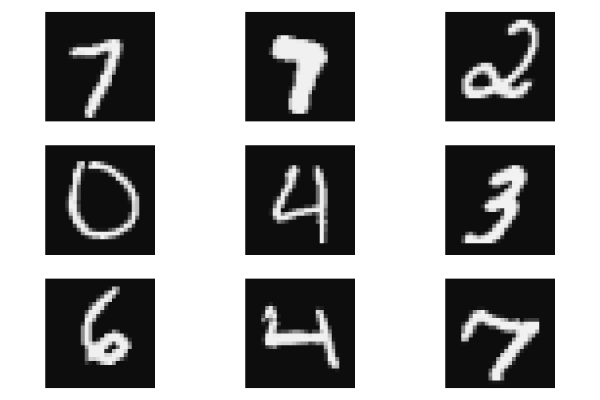

In [7]:
random_samples = rand(1:no_samples, 9);
plt = plot(layout = (3, 3), aspect_ratio = :equal, axis = false)

for (i, sample) in enumerate(random_samples)
    heatmap!(plt, 
        reshape(train_x[sample, :], no_pixels, no_pixels), 
        subplot = i, 
        yflip = true, 
        color = :grays, 
        colorbar = false, 
        axis = nothing)
end

display(plt)

In [13]:
mutable struct PCA
    fit_data::Matrix{Float64}
    eigenvalues::Vector{Float64}
    eigenvectors::Matrix{Float64}
end

function PCA(X::Matrix{Float64})
    
    X_center = X .- mean(X, dims = 2)
    
    cov_mat = cov(X_center)
    
    eigen_object = eigen(Symmetric(cov_mat))
    eigen_values, eigen_vectors = eigen_object.values, eigen_object.vectors
    
    sorted_idx = sortperm(eigen_values, rev = true)
    sorted_eigenvalues = eigen_values[sorted_idx]
    sorted_eigenvectors = eigen_vectors[:, sorted_idx]
    
    return PCA(X, sorted_eigenvalues, sorted_eigenvectors)
end
    
function transform(pca_model::PCA, X::Matrix{Float64}, n_components::Int64)
    
    centered_X = X .- mean(X, dims = 2)
    
    eigenvector_subset = pca_model.eigenvectors[:, 1:n_components]
    eigenvalues_subset = pca_model.eigenvalues[1:n_components]
    
    x_reduced = centered_X * eigenvector_subset
    
    return x_reduced, eigenvalues_subset
end

transform (generic function with 1 method)

In [18]:
pca_model = PCA(train_x)
train_features, train_eigenvals = transform(pca_model, train_x, 100)
test_features, _ = transform(pca_model, test_x, 100);

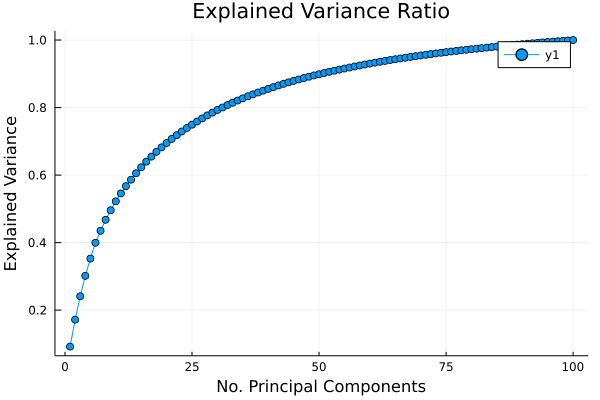

In [19]:
explained_variance = cumsum(train_eigenvals) ./ sum(train_eigenvals)
plot(1:length(explained_variance), explained_variance, title = "Explained Variance Ratio", marker = true, lw = 1)
xlabel!("No. Principal Components")
ylabel!("Explained Variance")

In [20]:
writedlm("train_features.txt", train_features)
writedlm("test_features.txt", test_features)